 - 作業一 額外功課

In [9]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from torch.optim import Adam
from torch.nn import BCEWithLogitsLoss # with sigmoid
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.preprocessing import MinMaxScaler

 - 定義Dataset

In [10]:
class cancerData(Dataset):
    def __init__(self, isTrain=True, test_size=0.2):
        super().__init__()
        self.isTrain = isTrain
        X_train, y_train = load_breast_cancer(return_X_y=True)
        
        # Preprocessing
        X_train = MinMaxScaler().fit_transform(X_train)
        X_train = torch.from_numpy(X_train.astype(np.float32))
        y_train = torch.from_numpy(y_train.astype(np.float32)).reshape(-1, 1)
        
        # Split
        X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=test_size)
        
        if isTrain: self.data, self.label = X_train, y_train
        else: self.data, self.label = X_test, y_test
    def __len__(self):
        return len(self.label)
    def __getitem__(self, index):
        return self.data[index], self.label[index]
        

In [11]:
# Hyper-parameter
batch_size = 32
epochs = 50

In [ ]:
train_data = cancerData(isTrain=True) # 訓練資料
test_data = cancerData(isTrain=False) # 測試資料

train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [13]:
class Module(nn.Module):
    def __init__(self):
        super(Module, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(30, 60),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(60, 20),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(20, 1),
            # nn.Sigmoid() 
        )
    def forward(self, X):
        return self.net(X)
    

In [ ]:
model = Module()
optimizer = Adam(model.parameters())
loss = BCEWithLogitsLoss()
history = {'acc':[], 'val_acc':[], 'loss':[], 'val_loss':[]} # 儲存訓練過程

In [15]:
for i in range(epochs):
    print(f'===== Epoch {i + 1} start! ====================')
    model.train()
    training_acc = 0
    training_loss = 0
    for data in train_loader:
        frame, label = data
        output = model(frame)
        output_loss = loss(output, label)
        # Record
        training_acc = training_acc + ((nn.Sigmoid()(output) >= 0.5) == label).sum().item()
        training_loss = training_loss + output_loss.item()
        # BP
        optimizer.zero_grad()
        output_loss.backward()
        optimizer.step()
    training_acc = training_acc / len(train_data)
    training_loss = training_loss / len(train_data)
    history['loss'].append(training_loss)
    history['acc'].append(training_acc)    
    
    model.eval()
    test_acc = 0
    test_loss = 0
    with torch.no_grad():
        for data in test_loader:
            frame, label = data
            output = model(frame)
            output_loss = loss(output, label)
            test_acc = test_acc + ((nn.Sigmoid()(output) >= 0.5) == label).sum().item()
            test_loss = test_loss + output_loss.item()
    test_acc = test_acc / len(test_data)
    test_loss = test_loss / len(test_data)
    history['val_acc'].append(test_acc)
    history['val_loss'].append(test_loss)
    
    print(f'Training acc: {training_acc:.4f}, training loss: {training_loss:.4f}')
    print(f'Test acc: {test_acc:.4f}, test loss: {test_loss:.4f}')

===== Epoch 1 start! ====================
Training acc: 0.5890, training loss: 0.0227
Test acc: 0.6491, test loss: 0.0239
===== Epoch 2 start! ====================
Training acc: 0.7231, training loss: 0.0222
Test acc: 0.6930, test loss: 0.0234
===== Epoch 3 start! ====================
Training acc: 0.7099, training loss: 0.0219
Test acc: 0.7544, test loss: 0.0228
===== Epoch 4 start! ====================
Training acc: 0.7956, training loss: 0.0209
Test acc: 0.8333, test loss: 0.0217
===== Epoch 5 start! ====================
Training acc: 0.7846, training loss: 0.0201
Test acc: 0.8772, test loss: 0.0202
===== Epoch 6 start! ====================
Training acc: 0.8330, training loss: 0.0190
Test acc: 0.9123, test loss: 0.0185
===== Epoch 7 start! ====================
Training acc: 0.8396, training loss: 0.0173
Test acc: 0.9123, test loss: 0.0164
===== Epoch 8 start! ====================
Training acc: 0.8747, training loss: 0.0156
Test acc: 0.9211, test loss: 0.0143
===== Epoch 9 start! ===

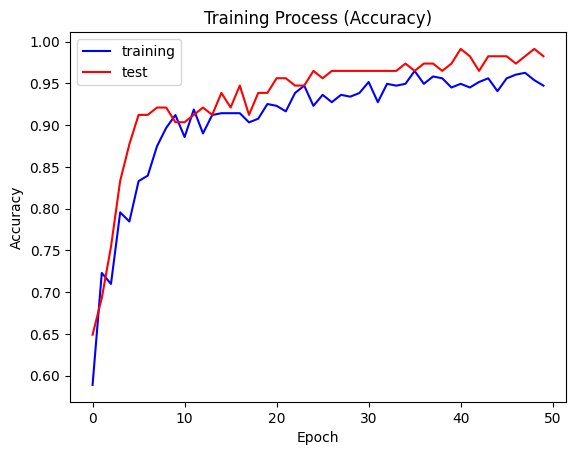

In [16]:
plt.cla(); plt.clf()
plt.plot(history['acc'], 'b', label='training')
plt.plot(history['val_acc'], 'r', label='test')
plt.legend()
plt.title('Training Process (Accuracy)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

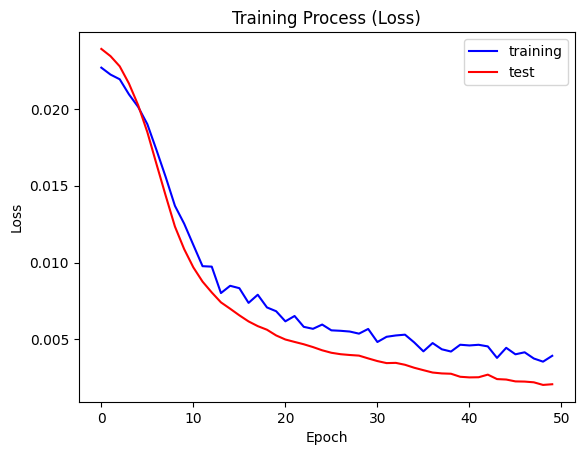

In [17]:
plt.cla(); plt.clf()
plt.plot(history['loss'], 'b', label='training')
plt.plot(history['val_loss'], 'r', label='test')
plt.legend()
plt.title('Training Process (Loss)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [18]:
from torchsummary import summary
summary(model, (30, ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 60]           1,860
              ReLU-2                   [-1, 60]               0
           Dropout-3                   [-1, 60]               0
            Linear-4                   [-1, 20]           1,220
              ReLU-5                   [-1, 20]               0
           Dropout-6                   [-1, 20]               0
            Linear-7                    [-1, 1]              21
Total params: 3,101
Trainable params: 3,101
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


 - Testing

In [19]:
pred_label = []
true_label = []
for data in test_loader:
    frame, label = data
    output = model(frame)
    true_label.extend(label)
    pred_label.extend(nn.Sigmoid()(output) >= 0.5)
    
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
print('\033[33m' + 'Breast Cancer Dataset Outcome' + '\033[0m')
print(f'Accuracy {accuracy_score(true_label, pred_label):.4f}')
print(f'Precision {precision_score(true_label, pred_label):.4f}')
print(f'Recall {recall_score(true_label, pred_label):.4f}')
print(f'F1 Score {f1_score(true_label, pred_label):.4f}')
print('Classification Report')
print(classification_report(true_label, pred_label, target_names=['real', 'positive']))

Breast Cancer Dataset Outcome
Accuracy 0.9825
Precision 0.9718
Recall 1.0000
F1 Score 0.9857
Classification Report
              precision    recall  f1-score   support

        real       1.00      0.96      0.98        45
    positive       0.97      1.00      0.99        69

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114

